# `Autoencoders for Anomaly Detection and Class Imbalance`

## Problem: Device Failure Prediction 
Predictive maintenance is used to minimize cost over routine or time-based maintenance. If any device gets failed it is a loss to company because it hinders business. Otherwise regular maintenance activities are also cost to company. Therefore our job is to predict when the device fails(**Preventive maintenance**).
We will try to reduce `False Positives` and `False Negatives`
## Data:
We have been given `device_failure.csv` which depicts the date-time a device has failed with 9 other masked features. The data is highly imbalanced `99.91% False cases and 0.08 % True cases`. There are other imbalanced datasets such as credit card fraud detection from `kaggle` which we will be working in part II
## Approach:

There are some ususal recommendations for working on Class Imbalance such as:
 - Data Level 
  - Oversampling the minority class.
  - Undersampling the majority class.
  - Combination of OverSampling and UnderSampling.
  - Synthesize new minority classes.(SMOTE)
 - Algorithm Level
  - Use class weights (higher weights for minority class)
  - Use different classification threshold rather tha default 0.5
  - Use complex tree based algorithms  like XGBoost / LightGBM etc.
  - Focus on specific metric (Precision/Recall/F1-Score).
  - Ensemble of Algorithms.
  - Cross Validation strategy with StratifiedKFold.
  - Neural Networks and Deep Learning.
 - Semi-Supervised Learning
  - Instead of Classification, reframe problem as Anomaly detection, a.k.a. outlier detection
  - `AutoEncoders` to the rescue 
 - Buy or Create more data
 - etc....


In our approach, we will use AutoEncoders, which has two aspects:- 

 -  We will be using the power of autoencoders to understand the hidden representation of the data. This part is also called **semi-supervised learning**
 - Then train(on ) and predict(test set) using simple linear algorithms and the lables given to us in .csv file. This part is called **supervised learning**

## Result:
Results show that Autoencoders work very well in case of class imbalance. 

## Resources:
 - Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. https://arxiv.org/abs/1502.03167
 - Very well written kernel on AutoEncoders https://www.kaggle.com/shivamb/semi-supervised-classification-using-autoencoders
 - imbalanced learn https://imbalanced-learn.readthedocs.io/en/stable/
 - t-SNE https://lvdmaaten.github.io/tsne/


In [1]:
# usual imports
import pandas as pd
import numpy as np
import time, gc, os, sys
seed = 42
np.random.seed(seed)

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
gc.collect()

import tensorflow as tf
print("Tensorflow version", tf.__version__)

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score

Tensorflow version 2.0.0-alpha0


In [2]:
print("reading data")
df = pd.read_csv("device_failure.csv", parse_dates=["date"])
df = df.sample(frac=1.0).reset_index(drop=True)
print("shape", df.shape)
df.head()

reading data
shape (124494, 12)


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-02-22,S1F0TPJC,0,1001640,0,10,0,12,272209,0,0,42
1,2015-08-12,Z1F0LVEM,0,123408536,0,0,6,57,251195,0,0,1
2,2015-04-13,W1F15P5S,0,59560608,0,0,0,8,214289,0,0,0
3,2015-09-07,S1F0AADQ,0,61141312,0,0,0,8,430298,0,0,1
4,2015-04-09,W1F0J9KM,0,191944064,0,0,0,9,280342,0,0,0


In [3]:
print("This shows the class imbalance")
print(df["failure"].value_counts())

print("Total unique devices = " , df["device"].nunique())

#print(" unique years ", df["date"].dt.year.unique())
#print(" unique months ",df["date"].dt.month.unique())

predictors = [c for c in df.columns if c not in ["date", "device","failure"]]
print("we will be using only below {} features as predictors".format(len(predictors)))
predictors

This shows the class imbalance
0    124388
1       106
Name: failure, dtype: int64
Total unique devices =  1168
we will be using only below 9 features as predictors


['attribute1',
 'attribute2',
 'attribute3',
 'attribute4',
 'attribute5',
 'attribute6',
 'attribute7',
 'attribute8',
 'attribute9']

In [4]:
# divide the dataset
df_failure = df[df["failure"] == 1] 
df_nonfailure_test = df[df["failure"] == 0].loc[:1000].reset_index(drop=True) # to be used later for testing
df_nonfailure = df[df["failure"] == 0].loc[1000:].reset_index(drop=True) # training set

# scale the input
df_failure[predictors] = MinMaxScaler().fit_transform(df_failure[predictors])
df_nonfailure[predictors] = MinMaxScaler().fit_transform(df_nonfailure[predictors])

print("shape of only failure data", df_failure.shape)
print("shape of training set", df_nonfailure.shape)
print("shape of test set", df_nonfailure_test.shape)


del df
gc.collect()

/home/rahul/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/rahul/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


shape of only failure data (106, 12)
shape of training set (123388, 12)
shape of test set (1001, 12)


7

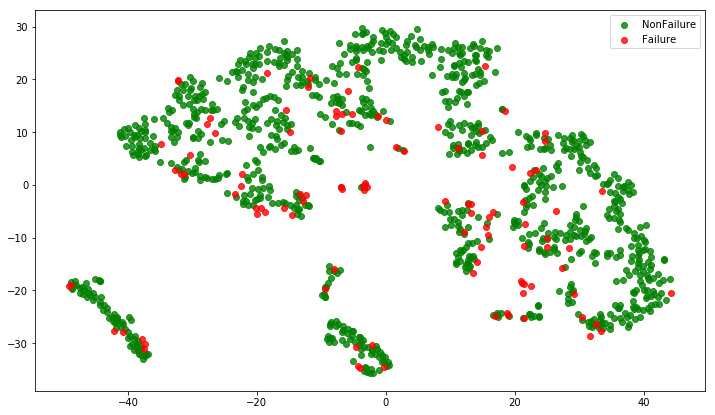

2449

In [5]:
# create the plotting helper function
def plot_tsne(x, y, name="classImbalance.png"):
    x_new = TSNE(random_state=seed).fit_transform(x)

    plt.figure(figsize=(12,7))
    plt.scatter(x_new[np.where(y == 0),0], x_new[np.where(y == 0),1],color='g',alpha=0.8,label="NonFailure")
    plt.scatter(x_new[np.where(y == 1),0], x_new[np.where(y == 1),1],color='r',alpha=0.8,label="Failure")
    plt.legend(loc='best')
    plt.savefig(name)
    plt.show()


    # visualize full failure data and just 500 samples from non failure data    
tmp = pd.concat([df_failure, df_nonfailure.loc[:1000]], axis=0)
plot_tsne(tmp[predictors], tmp["failure"])

del tmp
gc.collect()

### As can be clearly seen from fig above that data is not linearly separable

In [6]:
# create a model
def create_model(print_summary=True):
    inp = Input(shape=(len(predictors),), name="inp")

    inp1 = Dense(len(predictors))(inp)
    inp1 = BatchNormalization()(inp1)
    inp1 = Activation('relu')(inp1)
    
    latent = Dense(4)(inp1)
    latent = BatchNormalization()(latent)
    latent = Activation('relu')(latent)

    out = Dense(len(predictors))(latent)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)

    model = Model(inp, out)

    model.compile(optimizer='adam',loss='mse')
    
    if print_summary:
        print(model.summary())
    
    return model

model = create_model(print_summary=True)


# train the model
history = model.fit(df_nonfailure[predictors],df_nonfailure[predictors],
                    batch_size=32,epochs=5,validation_split=0.2)

model.layers

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             [(None, 9)]               0         
_________________________________________________________________
dense (Dense)                (None, 9)                 90        
_________________________________________________________________
batch_normalization_v2 (Batc (None, 9)                 36        
_________________________________________________________________
activation (Activation)      (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 40        
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 4)                 16        
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0     

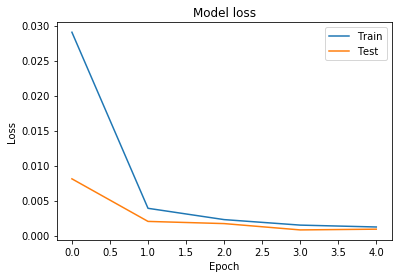

In [7]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

### now that our model is trained for 5 epochs and the train loss and val loss are similar and low, we can use the encoded layer (often called as bottleneck) to get latent representation of the data we trained on.


In [8]:
#  Obtain the Latent Representations
hid_repr = Sequential()
hid_repr.add(model.layers[0])
hid_repr.add(model.layers[1])
hid_repr.add(model.layers[2])
hid_repr.add(model.layers[3])
hid_repr.add(model.layers[4])
hid_repr.add(model.layers[5])
hid_repr.add(model.layers[6])

# predict on the hold out test set
hid_rep_nonfailure = hid_repr.predict(df_nonfailure_test[predictors])
# predict on data(with only POSITIVE Class)
hid_rep_failure = hid_repr.predict(df_failure[predictors])

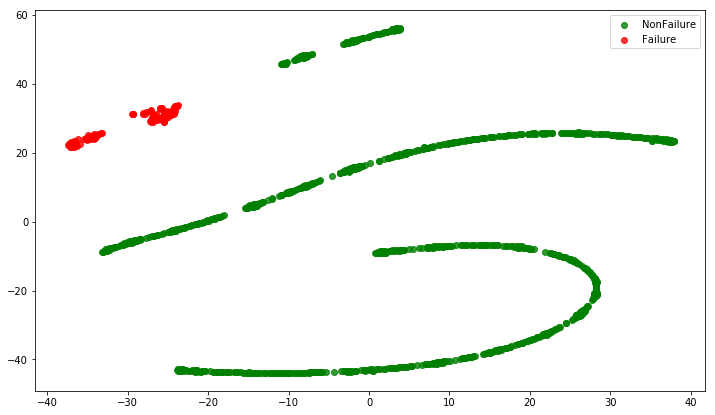

In [9]:
# visualize once again
rep_x = np.concatenate([hid_rep_failure, hid_rep_nonfailure], axis=0)
rep_x = TSNE(random_state=seed).fit_transform(rep_x)

f_y = np.ones(hid_rep_failure.shape[0])
n_y = np.zeros(hid_rep_nonfailure.shape[0])
rep_y = np.concatenate([f_y, n_y], axis=0)

# call the plotting helper function
plot_tsne(rep_x, rep_y, "transformedData.png")

### as can be seen from the above plot, the data is quiet linearly separable using a simple linear algorithm

In [10]:
# finally apply any simpler algo

train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=.25, random_state=seed)

lr = LogisticRegression(random_state=seed, n_jobs=-1)
lr.fit(train_x, train_y)
pred_y = lr.predict(val_x)

/home/rahul/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[[246   0]
 [  0  31]]


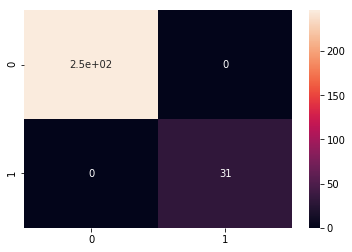

In [11]:
print(confusion_matrix(y_true=val_y, y_pred=pred_y))
sns.heatmap(confusion_matrix(y_true=val_y, y_pred=pred_y), annot=True)

In [12]:
print(classification_report(y_true=val_y, y_pred=pred_y))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       246
         1.0       1.00      1.00      1.00        31

   micro avg       1.00      1.00      1.00       277
   macro avg       1.00      1.00      1.00       277
weighted avg       1.00      1.00      1.00       277



# Conclusion

- First we divided the data into two parts as per the class labels.
 - Visualization shows the data is highly imbalanced and not linearly separable.
- Then we trained model on only majority class data(in our case label '0' - NonFailure)
- Then we get the hidden representation using the bottleneck layer(encoding layers) and transform the datasets (full POSITIVE label dataset(minority) and sample NEGATIVE dataset)
 - Visualization shows the data is linearly separable
- Train a simple linear model on the newly transformed data